In [1]:
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import math
import time

In [2]:
seed_num =  15
rnd = np.random
rnd.seed(seed_num)

In [3]:
#Parameters Declare:
n = 10 #number of clients
H = 3 # number of time periods
m = 3 #number of vehicle
mip_gap =.15
T = np.arange(1,H+1) # Time horizon index

r_sub = rnd.randint(10,100,size = n+1)
r = r_sub
for i in range(H-1):
    r =np.column_stack((r,r_sub))

r[0] = np.zeros((H,),dtype = int)
for i in range(1,n+1):
    r[0] = r[0]+ r[i] #made available units in depot
N_phay = np.arange(1,n+1) #client index
N = np.arange(0,n+1) #node index
U = rnd.choice((2,3),1)[0]*r[:,1] #maximum inventory level
I_0 = U-r[:,1] #Initial inventory level array
I_0[0]=np.sum(U[1:])
h =  rnd.randint(1,5,size =n+1) #holding cost
h[0] = 3

Q = 3/(2*m)*np.sum(r[1:,1]) # vehicle capacity

loc_x = rnd.rand(len(N))*500
loc_y = rnd.rand(len(N))*500
Cost = {(i,j): round(np.hypot(loc_x[i]-loc_x[j],loc_y[i]-loc_y[j]))for i in N for j in N if i!=j} #Moving cost matrix

Cost_2 = {(i,j): round(np.hypot(loc_x[i]-loc_x[j],loc_y[i]-loc_y[j]))for i in N for j in N if i<j} #Moving cost matrix2
cost_2_list = list(Cost_2.values())
cost_list_ultimate =[]
for i in range(len(cost_2_list)):
    for j in range(H):
        cost_list_ultimate += [cost_2_list[i]]
#cost_list_ultimate là chi phí ứng với từng y_i_j_t, khác với cost là ma trận chi phí di chuyển từ i đến j

rho = 2*10**3
mu = 10**3
epsilon =10**-6
epsilon_2 = 10**-4

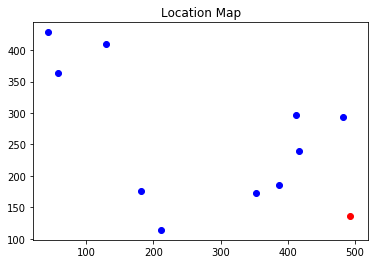

In [4]:
plt.scatter(loc_x[1:],loc_y[1:], c = 'b')
plt.scatter(loc_x[0],loc_y[0],c ='r')
plt.title('Location Map')
plt.show()

In [5]:
#Variable for easy indexing:
E = [(i,j) for i in N for j in N if i<j]
A = [(i,j) for i in N for j in N if i!=j]
E_with_T =  [(i,j,t) for i in N for j in N for t in T if i<j]
A_with_T = [(i,j,t) for i in N for j in N for t in T if i!=j] #set A with T
it_set = [(i,t) for i in N for t in T]
it_set_customer_only = [(i,t) for i in N_phay for t in T]

In [6]:
len_0 = len(E_with_T)  #0 -> y
len_1 = len_0 + len(it_set_customer_only) #len 0-> q
len_2 = len_1 + len(it_set) #len 0-> z
len_3 = len_2 + len(A_with_T) #len 0-> load
len_4 = len_3 + len(A_with_T) #len 0-> x
len_5 = len_4 + len(it_set) #len 0-> I

Since $$H_1(x) = 1/2 \rho \lVert x^k \rVert - lnf(x) - \mu P(x) $$ then <br>
$$y^k = \nabla H_1 (x^k) = \rho x^k -\nabla lnf(x^k) - \mu P(x^k)$$<br>
$P(X) =\sum(1-x)x $

Calculate $\rho x$ aka 1stTerm in the above equation ($y_k = ...$)

In [7]:
def d_1st_term(X):
    return rho*np.asarray(X)

Calculate $\nabla ln(ax)$, $a$ is constant (doesn't matter anw)

In [8]:
def d_2nd_term(X):
    result = np.zeros(len(X))
    for i in range(len(X)):
        if X[i] !=0:
            result[i]= 1/X[i]
        else:
            result[i] =0
    return result

Calculate $\nabla P(x)$

In [9]:
def d_3rd_term(X):
    return mu*(1-2*np.asarray(X))

In [10]:
def cal_y_k(X):
    result = np.zeros(len(X))
    result += d_1st_term(X)
    result[0:len_0] += -d_2nd_term(X[0:len_0])
    result[len_0:len_1] += d_2nd_term(X[len_0:len_1])
    result[len_0:len_1] += -d_3rd_term(X[len_0:len_1])
    result[len_1:len_2] += -d_3rd_term(X[len_1:len_2])
    result[len_3:len_4] += -d_3rd_term(X[len_3:len_4])
    return result

In [11]:
def solve_DCA(y_k):
    model = Model("Graduation Thesis by ThaoNgCh") 
    
    #Variables Declaration:
    y = model.integer_var_dict(E_with_T,lb = 0,ub = 1,name = 'y')
    q = model.continuous_var_dict(it_set_customer_only,lb = 0, name = 'q') 
    z = model.binary_var_dict(it_set,lb = 0,ub = 1,name ='z') 
    load = model.continuous_var_dict(A_with_T,lb=0,name = 'load') 
    x = model.binary_var_dict(A_with_T,lb = 0,ub = 1,name = 'x') 
    I = model.continuous_var_dict(it_set,lb = 0,name = 'I') 

    #Objective Function
    G = model.sum(y[i]**2 for i in E_with_T)
    G += model.sum(q[i]**2 for i in it_set_customer_only)
    G += model.sum(z[i]**2 for i in it_set)
    G += model.sum(load[i]**2 for i in A_with_T)
    G += model.sum(x[i]**2 for i in A_with_T)
    G+= model.sum(I[i]**2 for i in it_set)
    G = 1/2*rho*G
    
    
    H  = model.sum(y[i]*y_k[0:len_0][j] for i,j in zip(E_with_T,range(len(y_k))))
    H += model.sum(q[i]*y_k[len_0:len_1][j] for i,j in zip(it_set_customer_only,range(len(y_k))))
    H += model.sum(z[i]*y_k[len_1:len_2][j] for i,j in zip(it_set,range(len(y_k))))
    H += model.sum(load[i]*y_k[len_2:len_3][j] for i,j in zip(A_with_T,range(len(y_k))))
    H += model.sum(x[i]*y_k[len_3:len_4][j] for i,j in zip(A_with_T,range(len(y_k))))
    H += model.sum(I[i]*y_k[len_4:len_5][j] for i,j in zip(it_set,range(len(y_k))))
    
    model.minimize(G-H)
    
    #Add constraints
    #model.add_constraint(model.sum((model.sum(Cost[i,j]*y[i,j,t] for t in T) for (i,j) in E))<=(current_local_sol-epsilon_2)*model.sum(model.sum(q[i,t] for t in T) for i in N_phay)) #BOund Constraints
    model.add_constraints(I[0,t] == I_0[0]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t ==1) #35
    model.add_constraints(I[0,t] == I[0,t-1]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t>1) #35.5
    model.add_constraints(I[i,t] == I_0[i] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t ==1) #36
    model.add_constraints(I[i,t] == I[i,t-1] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t >1) #36.5
    model.add_constraints(I[i,t] >=0 for i in N for t in T) #(37)
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I_0[i] for i in N_phay for t in T if t==1) #38
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I[i,t-1] for i in N_phay for t in T if t>1) #38.5
    model.add_constraints(q[i,t] <= U[i] - I_0[i] for i in N_phay for t in T if t==1) #39
    model.add_constraints(q[i,t] <= U[i] - I[i,t-1] for i in N_phay for t in T if t>1) #39.5
    model.add_constraints(q[i,t] <=U[i]*z[i,t] for i in N_phay for t in T) #40
    #model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) == 2*z[i,t] for i in N_phay for t in T) #41
    model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) +model.sum(y[j,i,t] for j in N if (j,i) in E) == 2*z[i,t] for i in N_phay for t in T) #41,remastered
    model.add_constraints(model.sum(load[i,j,t] for j in N if (i,j) in A)- model.sum(load[j,i,t] for j in N if(j,i) in A) == -q[i,t] for i in N for t in T if i in N_phay) #42 #check
    model.add_constraints(model.sum(load[0,j,t] for j in N if (0,j) in A) - model.sum(load[j,0,t] for j in N if (j,0) in A) == model.sum(q[k,t] for k in N_phay) for t in T) #42.5 #prety check 
    model.add_constraints(load[i,j,t] <= Q*x[i,j,t] for [i,j] in A  for t in T) #43 check
    model.add_constraints(model.sum(x[j,i,t] for j in N if (j,i) in A) -model.sum(x[i,j,t] for j in N if (i,j) in A) ==0 for i in N for t in T) #44check
    model.add_constraints(x[i,j,t]+x[j,i,t] == y[i,j,t] for [i,j] in E for t in T) #45
    model.add_constraints(model.sum(x[0,j,t] for j in N if (0,j) in A) <= m for t in T) #46
    #model.add_constraints(y[i,j,t] <= 1 for (i,j) in E for t in T) #49
    #model.add_constraints(y[0,j,t] <= 2 for j in N_phay for t in T) #50

    model.parameters.mip.tolerances.mipgap = mip_gap #set gap
    model.parameters.timelimit = 1200
    model.export_as_lp()
    solution = model.solve()#(log_output = True)
    if solution == None:
        return 'None','None','None'
    y_k = cal_y_k(np.asarray(solution.get_all_values()))
    tu_so = np.dot(solution.get_values(y[i] for i in E_with_T),cost_list_ultimate)
    mau_so = np.dot(solution.get_values(q[i] for i in it_set_customer_only),np.ones(len(q)))
    real_obj_value = tu_so/mau_so
    return solution,y_k,real_obj_value

## Find Initial Solution

In [12]:
model = Model("Archetti 2014 Model by ThaoNgCh")

#Variables Declare:
y = model.integer_var_dict(E_with_T,lb = 0,name = 'y') #Check
q = model.continuous_var_dict(it_set_customer_only,lb = 0, name = 'q') #Check
z = model.binary_var_dict(it_set,name ='z') #Check
load = model.continuous_var_dict(A_with_T,lb=0,name = 'load') #...
x = model.binary_var_dict(A_with_T,name = 'x') #Check
I = model.continuous_var_dict(it_set,lb = 0,name = 'I') #Check

#Objective Function
model.minimize(100) 

#Add constraints
model.add_constraints(I[0,t] == I_0[0]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t ==1) #35
model.add_constraints(I[0,t] == I[0,t-1]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t>1) #35.5
model.add_constraints(I[i,t] == I_0[i] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t ==1) #36
model.add_constraints(I[i,t] == I[i,t-1] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t >1) #36.5
model.add_constraints(I[i,t] >=0 for i in N for t in T) #(37)
#model.add_constraints(q[i,t] >=U[i]*z[i,t] - I_0[i] for i in N_phay for t in T if t==1) #38
#model.add_constraints(q[i,t] >=U[i]*z[i,t] - I[i,t-1] for i in N_phay for t in T if t>1) #38.5
model.add_constraints(q[i,t] <= U[i] - I_0[i] for i in N_phay for t in T if t==1) #39
model.add_constraints(q[i,t] <= U[i] - I[i,t-1] for i in N_phay for t in T if t>1) #39.5
model.add_constraints(q[i,t] <=U[i]*z[i,t] for i in N_phay for t in T) #40
#model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) == 2*z[i,t] for i in N_phay for t in T) #41
model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) +model.sum(y[j,i,t] for j in N if (j,i) in E) == 2*z[i,t] for i in N_phay for t in T) #41,remastered
model.add_constraints(model.sum(load[i,j,t] for j in N if (i,j) in A)
                      - model.sum(load[j,i,t] for j in N if(j,i) in A) 
                      == -q[i,t] for i in N for t in T if i in N_phay) #42 #check
model.add_constraints(model.sum(load[0,j,t] for j in N if (0,j) in A)
                      - model.sum(load[j,0,t] for j in N if (j,0) in A) 
                      == model.sum(q[k,t] for k in N_phay) for t in T) #42.5 #prety check 
model.add_constraints(load[i,j,t] <= Q*x[i,j,t] for [i,j] in A  for t in T) #43 check
model.add_constraints(model.sum(x[j,i,t] for j in N if (j,i) in A) -model.sum(x[i,j,t] for j in N if (i,j) in A) ==0 for i in N for t in T) #44check
model.add_constraints(x[i,j,t]+x[j,i,t] == y[i,j,t] for [i,j] in E for t in T) #45
model.add_constraints(model.sum(x[0,j,t] for j in N if (0,j) in A) <= m for t in T) #46
model.add_constraints(y[i,j,t] <= 1 for (i,j) in E for t in T) #49
#model.add_constraints(y[0,j,t] <= 2 for j in N_phay for t in T) #50

#model.add_constraint(model.sum(model.sum(q[i,t] for t in T) for i in N_phay) >=dMin) #z(D)>= D_k_min
model.parameters.mip.tolerances.mipgap = mip_gap #set gap
model.parameters.timelimit = 6000
feasible_sol = model.solve()#(log_output = True)

In [32]:
x_0  =best_nghiem.get_all_values()

x_k = np.asarray(x_0)
init_obj_value = np.dot(x_k[0:len_0],cost_list_ultimate)/np.sum(x_k[len_0:len_1])

print('Initial Value is ',init_obj_value)
y_k = cal_y_k(x_k)
while True:
    x_k_old = np.asarray(x_k)
    solve_DCA(y_k)
    sol,y_k,real_obj_value = solve_DCA(y_k)
    cur_sol = sol.objective_value
    x_k = np.asarray(sol.get_all_values())
    diff = x_k-x_k_old
    print('Current Optimal Value is ',real_obj_value)
    if np.dot(diff,diff) <= epsilon*(np.dot(x_k,x_k)+1):
        print('Finished, Optimal Value is ',real_obj_value)
        break
        

Initial Value is  2.8865619546247827
Current Optimal Value is  2.8865619546247814
Current Optimal Value is  2.886561954624781
Current Optimal Value is  2.886561954624781
Current Optimal Value is  2.8865619546247827
Finished, Optimal Value is  2.8865619546247827


# DA3

In [19]:
def solve_upper(dMin):
    global D_min
    
    model = Model("Archetti 2018 Model upper by ThaoNgCh")
    
    #Variables Declare:
    y = model.integer_var_dict(E_with_T,lb = 0,name = 'y') #Check
    q = model.continuous_var_dict(it_set_customer_only,lb = 0, name = 'q') #Check
    z = model.binary_var_dict(it_set,name ='z') #Check
    load = model.continuous_var_dict(A_with_T,lb=0,name = 'load') #...
    x = model.binary_var_dict(A_with_T,name = 'x') #Check
    I = model.continuous_var_dict(it_set,lb = 0,name = 'I') #Check
    
    #Objective Function
    model.minimize(model.sum((model.sum(Cost[i,j]*y[i,j,t] for t in T) for (i,j) in E)))
    
    #Add constraints
    model.add_constraints(I[0,t] == I_0[0]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t ==1) #35
    model.add_constraints(I[0,t] == I[0,t-1]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t>1) #35.5
    model.add_constraints(I[i,t] == I_0[i] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t ==1) #36
    model.add_constraints(I[i,t] == I[i,t-1] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t >1) #36.5
    model.add_constraints(I[i,t] >=0 for i in N for t in T) #(37)
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I_0[i] for i in N_phay for t in T if t==1) #38
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I[i,t-1] for i in N_phay for t in T if t>1) #38.5
    model.add_constraints(q[i,t] <= U[i] - I_0[i] for i in N_phay for t in T if t==1) #39
    model.add_constraints(q[i,t] <= U[i] - I[i,t-1] for i in N_phay for t in T if t>1) #39.5
    model.add_constraints(q[i,t] <=U[i]*z[i,t] for i in N_phay for t in T) #40
    #model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) == 2*z[i,t] for i in N_phay for t in T) #41
    model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) +model.sum(y[j,i,t] for j in N if (j,i) in E) == 2*z[i,t] for i in N_phay for t in T) #41,remastered
    model.add_constraints(model.sum(load[i,j,t] for j in N if (i,j) in A)- model.sum(load[j,i,t] for j in N if(j,i) in A) == -q[i,t] for i in N for t in T if i in N_phay) #42 #check
    model.add_constraints(model.sum(load[0,j,t] for j in N if (0,j) in A) - model.sum(load[j,0,t] for j in N if (j,0) in A) == model.sum(q[k,t] for k in N_phay) for t in T) #42.5 #prety check 
    model.add_constraints(load[i,j,t] <= Q*x[i,j,t] for [i,j] in A  for t in T) #43 check
    model.add_constraints(model.sum(x[j,i,t] for j in N if (j,i) in A) -model.sum(x[i,j,t] for j in N if (i,j) in A) ==0 for i in N for t in T) #44check
    model.add_constraints(x[i,j,t]+x[j,i,t] == y[i,j,t] for [i,j] in E for t in T) #45
    model.add_constraints(model.sum(x[0,j,t] for j in N if (0,j) in A) <= m for t in T) #46
    model.add_constraints(y[i,j,t] <= 1 for (i,j) in E for t in T) #49
    model.add_constraints(y[0,j,t] <= 2 for j in N_phay for t in T) #50
    
    model.add_constraint(model.sum(model.sum(q[i,t] for t in T) for i in N_phay) >=dMin) #z(D)>= D_k_min
    model.parameters.mip.tolerances.mipgap = mip_gap #set gap
    model.parameters.timelimit = 6000
    solution = model.solve()#(log_output = True)
    if solution == None:
        return "r_best",r_best
    else:
        return "z_R_star",solution.get_objective_value(),solution

In [20]:
def solve_below(zRStar):
    global D_min
    global z_R_star
    model = Model("Archetti 2018 Model below by ThaoNgCh")
    
    #Variables Declare:
    y = model.integer_var_dict(E_with_T,lb = 0,name = 'y') #Check
    q = model.continuous_var_dict(it_set_customer_only,lb = 0, name = 'q') #Check
    z = model.binary_var_dict(it_set,name ='z') #Check
    load = model.continuous_var_dict(A_with_T,lb=0,name = 'load') #...
    x = model.binary_var_dict(A_with_T,name = 'x') #Check
    I = model.continuous_var_dict(it_set,lb = 0,name = 'I') #Check
    
    #Objective Function
    model.maximize(model.sum(model.sum(q[i,t] for t in T) for i in N_phay)) #Maximizing z(D)
    
    #Add constraints
    model.add_constraints(I[0,t] == I_0[0]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t ==1) #35
    model.add_constraints(I[0,t] == I[0,t-1]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t>1) #35.5
    model.add_constraints(I[i,t] == I_0[i] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t ==1) #36
    model.add_constraints(I[i,t] == I[i,t-1] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t >1) #36.5
    model.add_constraints(I[i,t] >=0 for i in N for t in T) #(37)
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I_0[i] for i in N_phay for t in T if t==1) #38
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I[i,t-1] for i in N_phay for t in T if t>1) #38.5
    model.add_constraints(q[i,t] <= U[i] - I_0[i] for i in N_phay for t in T if t==1) #39
    model.add_constraints(q[i,t] <= U[i] - I[i,t-1] for i in N_phay for t in T if t>1) #39.5
    model.add_constraints(q[i,t] <=U[i]*z[i,t] for i in N_phay for t in T) #40
    #model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) == 2*z[i,t] for i in N_phay for t in T) #41
    model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) +model.sum(y[j,i,t] for j in N if (j,i) in E) == 2*z[i,t] for i in N_phay for t in T) #41,remastered
    model.add_constraints(model.sum(load[i,j,t] for j in N if (i,j) in A)- model.sum(load[j,i,t] for j in N if(j,i) in A) == -q[i,t] for i in N for t in T if i in N_phay) #42 #check
    model.add_constraints(model.sum(load[0,j,t] for j in N if (0,j) in A) - model.sum(load[j,0,t] for j in N if (j,0) in A) == model.sum(q[k,t] for k in N_phay) for t in T) #42.5 #prety check 
    model.add_constraints(load[i,j,t] <= Q*x[i,j,t] for [i,j] in A  for t in T) #43 check
    model.add_constraints(model.sum(x[j,i,t] for j in N if (j,i) in A) -model.sum(x[i,j,t] for j in N if (i,j) in A) ==0 for i in N for t in T) #44check
    model.add_constraints(x[i,j,t]+x[j,i,t] == y[i,j,t] for [i,j] in E for t in T) #45
    model.add_constraints(model.sum(x[0,j,t] for j in N if (0,j) in A) <= m for t in T) #46
    model.add_constraints(y[i,j,t] <= 1 for (i,j) in E for t in T) #49
    model.add_constraints(y[0,j,t] <= 2 for j in N_phay for t in T) #50
    
    #Differences come from here
    model.add_constraint(model.sum(model.sum(Cost[i,j]*y[i,j,t] for t in T) for (i,j) in E) <= zRStar) #status_upper[1] is z*(R) value 
    model.parameters.mip.tolerances.mipgap = mip_gap #set gap
    model.parameters.timelimit = 600 # set time_limit = 10 mins
    solution = model.solve()#(log_output = True)
    if solution == None:
        return "cant_solve",r_best
    else:
        return "z_D_star",solution.get_objective_value(),solution

In [21]:
k =0
r_best = float('inf')
D_min = 0

#Calculate D_max
sum1 = 0
sum2 = 0
for i in N_phay:
    sum1 =sum1 + max(np.array([r[i,t-1] for t in range(1,m+1)]).sum() - I_0[i],0)
for i in N_phay:
    sum2 =sum2 + (U[i]-r[i,H-1]- max(-np.array([r[i,t-1] for t in range(1,m+1)]).sum() + I_0[i],0))
D_max = min(H*Q*m,sum1+sum2)

In [22]:
print("seed = ",seed_num)
print("gap = ",mip_gap)
print("Number of customers = ",n)
print("Number of time periods = ",H)
print ("Number of vehicles = ",m)
start_time = time.time()
while True:
    print("\n-------Iteration number k= ",k+1,"-------")
    status_upper = solve_upper(D_min)
    if status_upper[0] =="r_best":
        break
    z_R_star = status_upper[1]
    print("z_R_star= ",z_R_star)
    if z_R_star >=r_best*D_max:#line 10
        break
    while True:
        D_bar_min = math.ceil(z_R_star/r_best) +1 #Line 13
        status_upper_bar = solve_upper(D_bar_min)
        if status_upper_bar[0] =="r_best": #line 15
            break
        if status_upper_bar[1] <=z_R_star:
            break
        else:
            z_R_star = status_upper_bar[1]
            print("z_R_star_bar = ",z_R_star)
    
    status_below = solve_below(z_R_star)
    z_D_star = status_below[1]
    print("z_D_star= ",z_D_star)
    if (z_R_star/z_D_star <r_best):
        best_nghiem = status_below[2]
        best_z_R_star = z_R_star
        best_z_D_star = z_D_star
        r_best = z_R_star/z_D_star
    k = k +1
    D_min = z_D_star +1
    LB = z_R_star/D_max
    print("r_best = ",r_best)
    print("LB = ",LB)
    print ("D_min = ",D_min)
    if(r_best<LB):
        x_k = status_below[2].get_all_values()
        break
        
end_time = time.time()
print("The Optimal Ratio is :",r_best)
print("Got after ",k," iterations")
print("CPU time = ",end_time -start_time)
print("With the value of z_R_star = ",best_z_R_star)
print("With the value of z_D_star = ",best_z_D_star)
#print ("CPU time = ",time.process_time ())

seed =  15
gap =  0.15
Number of customers =  10
Number of time periods =  3
Number of vehicles =  3

-------Iteration number k=  1 -------
z_R_star=  2004.999999999584
z_R_star_bar =  2045.9999999993274
z_D_star=  467.0
r_best =  4.381156316915048
LB =  1.4603854389716826
D_min =  468.0

-------Iteration number k=  2 -------
z_R_star=  2220.999999999809
z_D_star=  700.5
r_best =  3.1705924339754588
LB =  1.5852962169877294
D_min =  701.5

-------Iteration number k=  3 -------
z_R_star=  2476.0
z_R_star_bar =  2485.0
z_D_star=  859.4999999999998
r_best =  2.8912158231529967
LB =  1.7737330478229836
D_min =  860.4999999999998

-------Iteration number k=  4 -------
z_R_star=  2558.0
z_R_star_bar =  2601.0
z_R_star_bar =  2695.0
z_R_star_bar =  2775.0
z_R_star_bar =  2931.0
z_R_star_bar =  3173.0
z_R_star_bar =  3554.0
z_R_star_bar =  4087.0
z_D_star=  1198.000000000062
r_best =  2.8912158231529967
LB =  2.917201998572448
D_min =  1199.000000000062
The Optimal Ratio is : 2.891215823152996

In [31]:
best_nghiem.get_all_values()

[0,
 0,
 1.0,
 0,
 1.0,
 1.0,
 0,
 0,
 1.0,
 0,
 1.0,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.0,
 0,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 22.0,
 0,
 -1.9895196601282805e-13,
 44.999999999999986,
 0,
 0,
 10.0,
 0,
 0,
 113.99999999999999,
 0,
 37.0,
 0,
 0,
 0,
 201.5,
 0,
 0,
 152.49999999999997,
 0,
 95.0,
 0,
 0,
 101.5,
 0,
 0,
 0,
 81.0,
 0,
 0,
 0,
 0,
 0,
 1.0,
 0,
 1.0,
 1.0,
 0,
 0,
 1.0,
 0,
 1.0,
 1.0,
 0,
 1.0,
 0,
 0,
 0